# Seismic inversion of real data

This notebook is based on the respective [Segyio notebook](https://github.com/equinor/segyio-notebooks/blob/master/notebooks/pylops/01_seismic_inversion.ipynb) that presents a simple example of relative seismic inversion.

We will use [Kerry3D](https://wiki.seg.org/wiki/Kerry-3D) as input data to our inversion and we will leverage the open-source [TileDB-Segy](https://github.com/TileDB-Inc/TileDB-Segy/) and [pylops](https://github.com/equinor/pylops) libraries to accomplish our task as follows:

- Data is converted from the original SEG-Y file to [TileDB](https://tiledb.com/) arrays
- The converted data are uploaded to an AWS S3 bucket and registered on [TileDB Cloud](https://tiledb.com/cloud/)
- Relative seismic inversion is applied by means of [pylops.avo.poststack.PoststackInversion](https://pylops.readthedocs.io/en/latest/api/generated/pylops.avo.poststack.PoststackInversion.html)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import tiledb.segy
from pylops.avo.poststack import PoststackInversion

## Preparing the data

The original Kerry3D data can be be downloaded with the following command:

In [2]:
# TO BE RUN ONLY ONCE TO RETRIEVE THE DATA
#!wget http://s3.amazonaws.com/open.source.geoscience/open_data/newzealand/Taranaiki_Basin/Keri_3D/Kerry3D.segy

The SEG-Y file first needs to be converted to TileDB arrays using the `segy2tiledb` command line interface installed with `tiledb-segy`:

In [3]:
# TO BE RUN ONLY ONCE TO CONVERT THE DATA
#!segy2tiledb --iline=223 --xline=21 Kerry3D.segy

The converted arrays are stored under the `Kerry3d.tsgy` local directory. We then upload this directory to an AWS S3 bucket:

In [4]:
!tree -L 2 Kerry3D.tsgy
# TO BE RUN ONLY ONCE TO UPLOAD THE DATA
# !aws s3 sync Kerry3D.tsgy s3://${YOUR_S3_BUCKET}/Kerry3D.tsgy

Kerry3D.tsgy
├── __tiledb_group.tdb
├── data
│   ├── __1607974279650_1607974286592_58999644af624d4187a978038aa1bfef_6
│   ├── __1607974279650_1607974286592_58999644af624d4187a978038aa1bfef_6.ok
│   ├── __array_schema.tdb
│   ├── __lock.tdb
│   └── __meta
└── headers
    ├── __1607974263183_1607974278160_d212af1cbaf14d43bab3c911d0aa1718_6
    ├── __1607974263183_1607974278160_d212af1cbaf14d43bab3c911d0aa1718_6.ok
    ├── __array_schema.tdb
    ├── __lock.tdb
    └── __meta

6 directories, 7 files


Finally we need to [register the arrays](https://docs.tiledb.com/cloud/console/arrays/registering-arrays) in TileDB Cloud. 

**_NOTE:_**  As of December 2020, TileDB Cloud does not support registering multiple arrays as a single [TileDB group](https://docs.tiledb.com/main/basic-concepts/data-format#groups). Since the converted SEG-Y consists of two arrays (`data` for trace data and `headers` for trace headers), we have to register them separately. 

In the next section we will access the data from the following shared [public arrays](https://docs.tiledb.com/cloud/console/arrays/public-arrays):
- [Kerry3D-data](https://console.tiledb.com/arrays/details/george.sakkis/Kerry3d-data/overview)
- [Kerry3D-headers](https://console.tiledb.com/arrays/details/george.sakkis/Kerry3d-headers/overview)


## Accessing and displaying the data

First let's read our seismic data from TileDB Cloud and display it:

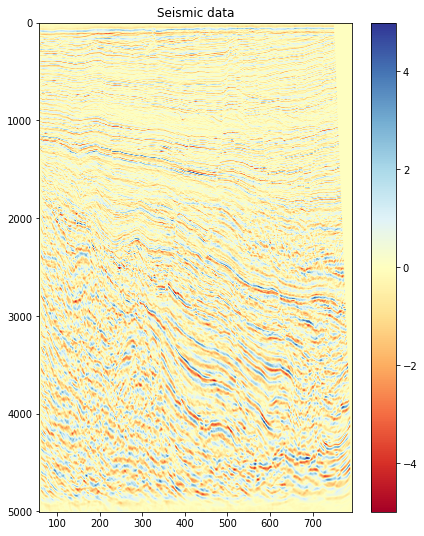

In [5]:
f = tiledb.segy.open2(data_uri='tiledb://george.sakkis/Kerry3d-data',
                      headers_uri='tiledb://george.sakkis/Kerry3d-headers')

il, xl, t = f.ilines, f.xlines, f.samples
dt = t[1] - t[0]

d = f.cube()
nil, nxl, nt = d.shape

plt.figure(figsize=(7, 9))
plt.imshow(d[nil//2].T, cmap='RdYlBu', vmin=-5, vmax=5,
           extent=(xl[0], xl[-1], t[-1], t[0]))
plt.title('Seismic data')
plt.colorbar()
plt.axis('tight');

## Getting a wavelet estimate

Let's now try to get a quick estimate of the wavelet in our data using a simple *statistical wavelet* estimation in frequency domain.

Note that this notebook is not focused on the pre-processing but we will need access to this to apply a relative seismic inversion.

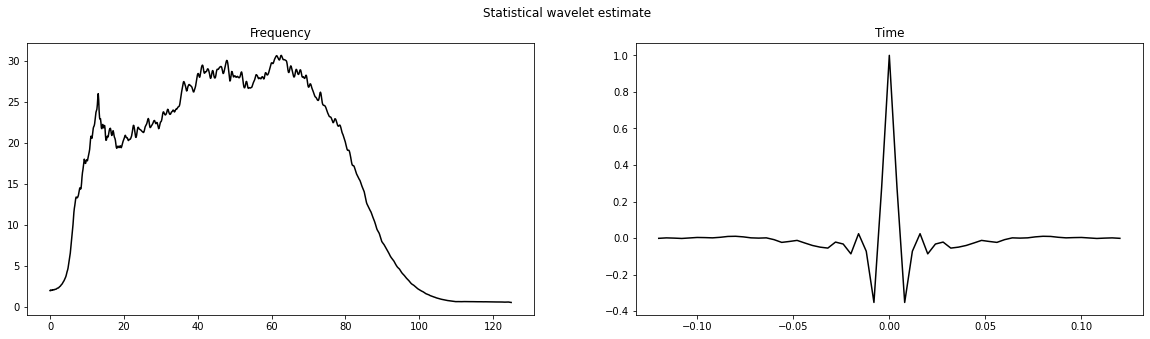

In [6]:
nt_wav = 31 # lenght of wavelet in samples
nfft = 2**11 # lenght of fft

# time axis for wavelet
t_wav = np.arange(nt_wav) * (dt/1000) 
t_wav = np.concatenate((np.flipud(-t_wav[1:]), t_wav), axis=0)

# estimate wavelet spectrum
wav_est_fft = np.mean(np.abs(np.fft.fft(d[..., :500], nfft, axis=-1)), axis=(0, 1))
fwest = np.fft.fftfreq(nfft, d=dt/1000)

# create wavelet in time
wav_est = np.real(np.fft.ifft(wav_est_fft)[:nt_wav])
wav_est = np.concatenate((np.flipud(wav_est[1:]), wav_est), axis=0)
wav_est = wav_est / wav_est.max()
wcenter = np.argmax(np.abs(wav_est))

# display wavelet
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Statistical wavelet estimate')
axs[0].plot(fwest[:nfft//2], wav_est_fft[:nfft//2], 'k')
axs[0].set_title('Frequency')
axs[1].plot(t_wav, wav_est, 'k')
axs[1].set_title('Time');

## Applying relative seismic inversion 

Let's now perform the inversion:

In [7]:
# swap time axis to first dimension
d_small = d[..., :500]
d_small = np.swapaxes(d_small, -1, 0)

m_relative, r_relative = PoststackInversion(d_small, wav_est, m0=np.zeros_like(d_small), 
                                            explicit=True, epsI=1e-4, simultaneous=False)
m_relative_reg, r_relative_reg = PoststackInversion(d_small, wav_est, m0=m_relative, 
                                                    epsI=1e-4, epsR=1e0, iter_lim=10, show=2)
# swap time axis back to last dimension
d_small = np.swapaxes(d_small, 0, -1)
m_relative = np.swapaxes(m_relative, 0, -1)
m_relative_reg = np.swapaxes(m_relative_reg, 0, -1)
r_relative = np.swapaxes(r_relative, 0, -1)
r_relative_reg = np.swapaxes(r_relative_reg, 0, -1)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 210945000 rows and 105472500 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       10
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.184e+04  2.184e+04    1.0e+00  1.9e-04
     1  0.00000e+00   1.453e+04  1.453e+04    6.7e-01  6.2e-01   5.6e+00  1.0e+00
     2  0.00000e+00   1.065e+04  1.065e+04    4.9e-01  3.4e-01   8.2e+00  2.3e+00
     3  0.00000e+00   8.750e+03  8.750e+03    4.0e-01  2.3e-01   1.0e+01  3.8e+00
     4  0.00000e+00   7.556e+03  7.556e+03    3.5e-01  1.8e-01   1.1e+01  5.4e+00
     5  0.00000e+00   6.756e+03  6.756e+03    3.1e-01  1.4e-01   1.3e+01  7.2e+00
     6  0.00000e+00   6.231e+03  6.231e+03    2.9e-01  1.1e-01   1.4e+01  9.1e+00
     7  0.00000e+00   5.851e+03  5.851e+03    2.7e-01  8.9e-02   1.5e+01  1.1e+01
     8  0.00000e+00   5.

Let's compare our results:

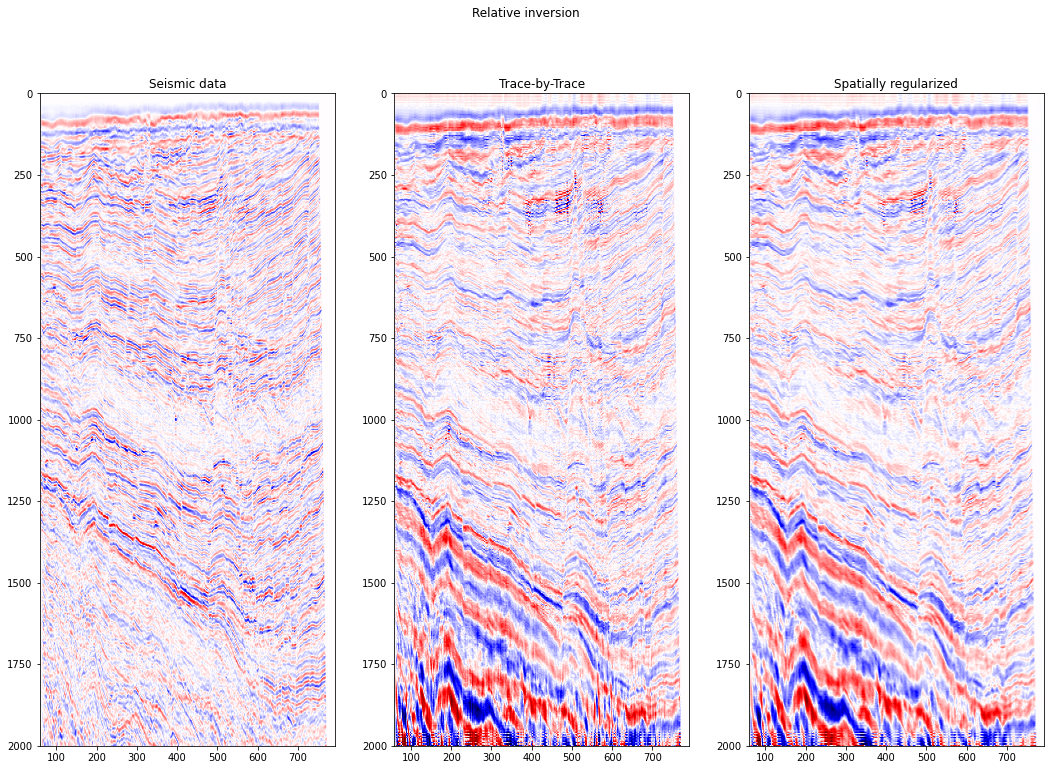

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(18, 12))
fig.suptitle('Relative inversion')
axs[0].imshow(d_small[nil//2].T, cmap='seismic', vmin=-10, vmax=10,
              extent=(xl[0], xl[-1], t[500], t[0]))
axs[0].set_title('Seismic data')
axs[0].axis('tight')
axs[1].imshow(m_relative[nil//2].T, cmap='seismic', vmin=-0.2*m_relative.max(), vmax=0.2*m_relative.max(),
              extent=(xl[0], xl[-1], t[500], t[0]))
axs[1].set_title('Trace-by-Trace')
axs[1].axis('tight')
axs[2].imshow(m_relative_reg[nil//2].T, cmap='seismic', vmin=-0.2*m_relative.max(), vmax=0.2*m_relative.max(),
              extent=(xl[0], xl[-1], t[500], t[0]))
axs[2].set_title('Spatially regularized')
axs[2].axis('tight');

And a little close up:

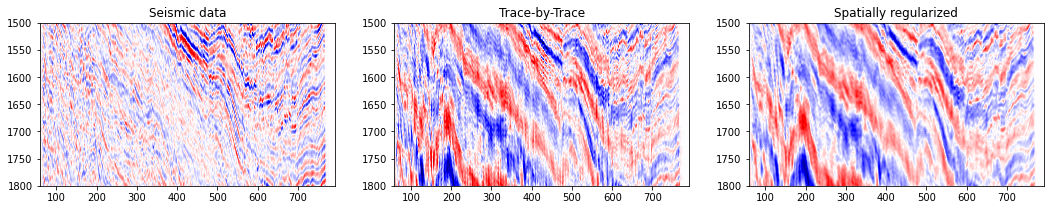

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(18, 3))
axs[0].imshow(d_small[nil//2].T, cmap='seismic', interpolation='sinc', vmin=-10, vmax=10,
              extent=(xl[0], xl[-1], t[500], t[0]))
axs[0].set_title('Seismic data')
axs[0].axis('tight')
axs[0].set_ylim(1800, 1500)
axs[1].imshow(m_relative[nil//2].T, cmap='seismic', interpolation='sinc', 
              vmin=-0.2*m_relative.max(), vmax=0.2*m_relative.max(),
              extent=(xl[0], xl[-1], t[500], t[0]))
axs[1].set_title('Trace-by-Trace')
axs[1].axis('tight')
axs[1].set_ylim(1800, 1500)
axs[2].imshow(m_relative_reg[nil//2].T, cmap='seismic', interpolation='sinc', 
              vmin=-0.2*m_relative.max(), vmax=0.2*m_relative.max(),
              extent=(xl[0], xl[-1], t[500], t[0]))
axs[2].set_title('Spatially regularized')
axs[2].axis('tight')
axs[2].set_ylim(1800, 1500);

And a time slice:

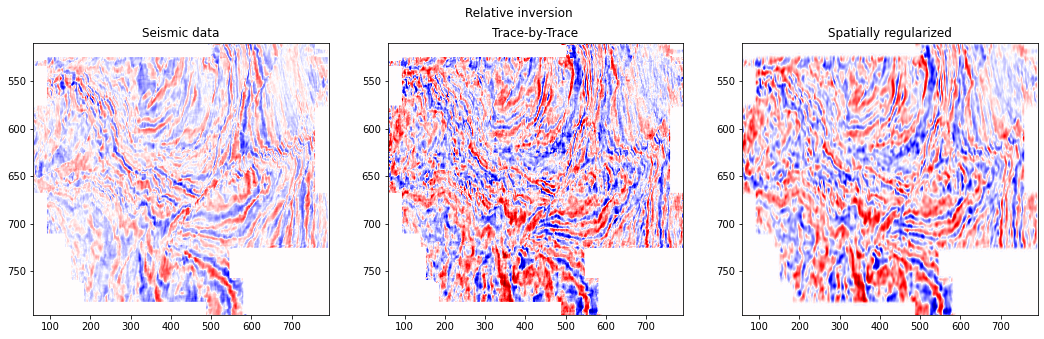

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Relative inversion')
axs[0].imshow(d_small[...,200], cmap='seismic', vmin=-10, vmax=10,
              extent=(xl[0], xl[-1], il[-1], il[0]))
axs[0].set_title('Seismic data')
axs[0].axis('tight');
axs[1].imshow(m_relative[...,200], cmap='seismic', vmin=-0.1*m_relative.max(), vmax=0.1*m_relative.max(),
              extent=(xl[0], xl[-1], il[-1], il[0]))
axs[1].set_title('Trace-by-Trace')
axs[1].axis('tight');
axs[2].imshow(m_relative_reg[...,200], cmap='seismic', vmin=-0.1*m_relative.max(), vmax=0.1*m_relative.max(),
              extent=(xl[0], xl[-1], il[-1], il[0]))
axs[2].set_title('Spatially regularized')
axs[2].axis('tight');

Finally we display the residuals:

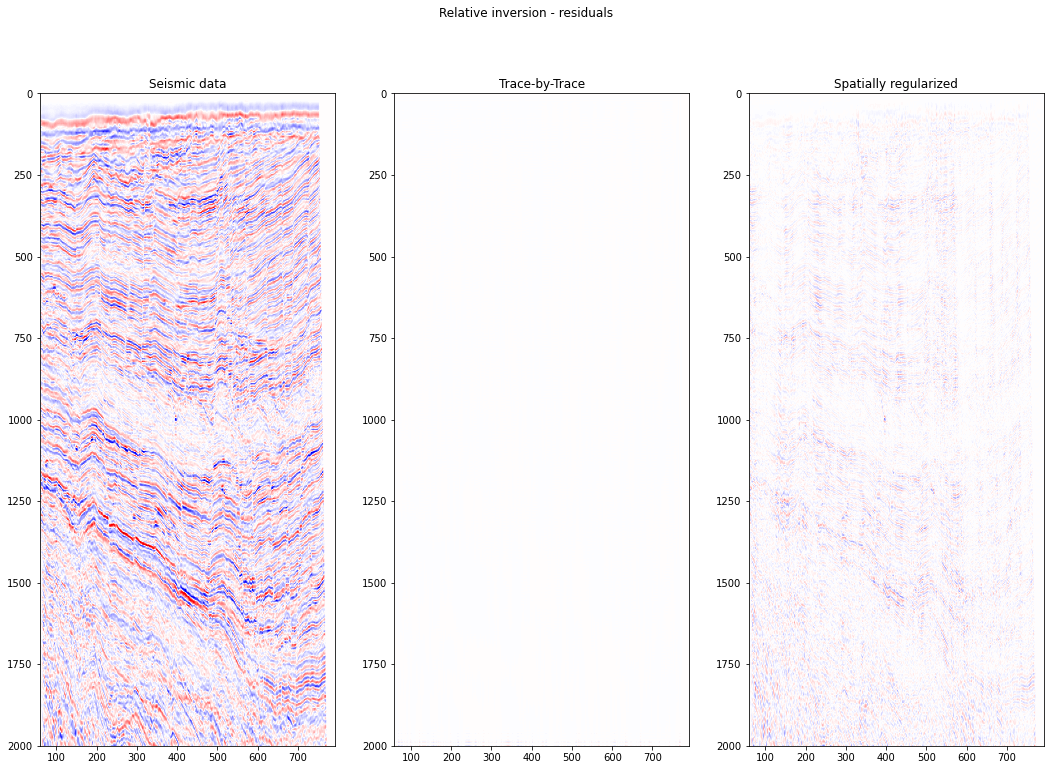

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(18, 12))
fig.suptitle('Relative inversion - residuals')
axs[0].imshow(d_small[nil//2].T, cmap='seismic', vmin=-10, vmax=10,
              extent=(xl[0], xl[-1], t[500], t[0]))
axs[0].set_title('Seismic data')
axs[0].axis('tight')
axs[1].imshow(r_relative[nil//2].T, cmap='seismic', vmin=-10, vmax=10, 
              extent=(xl[0], xl[-1], t[500], t[0]))
axs[1].set_title('Trace-by-Trace')
axs[1].axis('tight')
axs[2].imshow(r_relative_reg[nil//2].T, cmap='seismic', vmin=-10, vmax=10,
              extent=(xl[0], xl[-1], t[500], t[0]))
axs[2].set_title('Spatially regularized')
axs[2].axis('tight');